# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [ ]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')

DATA_DIR = 'drive/MyDrive/MLBD_Lernnavi_Data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf


## Task 0: Research Question

**Research question:**
*Predicting user motivation and retention. E.g., dropout or long pauses prediction, level checks prediction (self-supervised learning)*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [ ]:
# Create date column
events['date'] = pd.to_datetime(events['timestamp'], unit='ms')
events["week"] = events["date"].dt.isocalendar().week
events["year"] = events["date"].dt.year

In [ ]:
# User activity per week
df_weekly = events[["user_id","year","week"]].dropna().groupby(["user_id","year","week"]).size().reset_index(name='num_events')
df_weekly

,user_id,year,week,num_events
0,387604,2021,20,1
1,387604,2021,21,1
2,387604,2021,25,7
3,387604,2021,26,25
4,387604,2021,31,12
...,...,...,...,...
27527,404600,2022,8,34
27528,404603,2022,8,112
27529,404604,2022,8,43
27530,404605,2022,8,22


In [ ]:
# Number of questions answered and the evaluations per week
all_questions = events[["user_id","year","week","action","transaction_token"]].dropna()
all_questions = all_questions[all_questions['action']=='SUBMIT_ANSWER']

evaluations = all_questions.merge(transactions[['transaction_token', 'evaluation']].dropna().replace(["CORRECT","PARTIAL","WRONG"],[1,0.5,0]),
                                  on='transaction_token',
                                  how='left')

# Remove users that have a transaction in the event table that is not in the transaction table (~27000 / 400000)
evaluations = evaluations[evaluations['evaluation'].notna()]
num_questions = evaluations.drop(columns = ["transaction_token"]).groupby(
    ["user_id","year","week"]).size().reset_index(name='num_questions')
evaluations_count = evaluations.drop(columns = ["transaction_token"]).groupby(
    ["user_id","year","week"]).sum().reset_index()

df_questions = num_questions.merge(evaluations_count, on=['user_id', 'year', 'week'], how='left')
df_questions['percentage_correct'] = df_questions['evaluation'] / df_questions['num_questions']
df_questions = df_questions.drop(columns='evaluation')
df_questions

,user_id,year,week,num_questions,percentage_correct
0,387604,2021,35,1,0.000000
1,387604,2021,38,4,0.125000
2,387604,2021,39,2,0.750000
3,387604,2021,40,1,0.500000
4,387604,2021,41,1,0.500000
...,...,...,...,...,...
18526,404597,2022,8,1,0.500000
18527,404598,2022,8,1,1.000000
18528,404599,2022,8,1,1.000000
18529,404603,2022,8,13,0.653846


In [ ]:
# Number of theory pages read per week
num_theory = events[["user_id","year","week","action"]].dropna()
num_theory = num_theory[num_theory["action"]=='GO_TO_THEORY'].groupby(
    ["user_id","year","week"]).size().reset_index(name='num_theory')
num_theory

,user_id,year,week,num_theory
0,387604,2021,33,18
1,387604,2021,34,50
2,387604,2021,35,118
3,387604,2021,36,27
4,387604,2021,37,78
...,...,...,...,...
7858,404589,2022,8,4
7859,404597,2022,8,8
7860,404598,2022,8,15
7861,404599,2022,8,38


In [ ]:
# Filter out uneeded users and merge all tables
df_weekly_merged = df_weekly.copy()
df_weekly_merged = df_weekly_merged.merge(df_questions, on=['user_id', 'year', 'week'], how='left').fillna(value={'num_questions':0})
df_weekly_merged = df_weekly_merged.merge(num_theory, on=['user_id', 'year', 'week'], how='left').fillna(value={'num_theory':0})

# Sort the data per date and renumber the weeks
df_weekly_merged = df_weekly_merged.sort_values(by = ["user_id","year","week"])
df_weekly_merged["week"] = df_weekly_merged.groupby('user_id').cumcount()
df_weekly_merged = df_weekly_merged.drop(columns = ["year"])

# Check which week is the last week of activity of the user
s = df_weekly_merged['user_id'].shift(-1)
df_weekly_merged['last_week_of_activity'] = df_weekly_merged['user_id'].ne(s)

df_weekly_merged

# User example
df_weekly_merged[df_weekly_merged['user_id']==df_weekly_merged['user_id'].unique()[0]]

,user_id,week,num_events,num_questions,percentage_correct,num_theory,last_week_of_activity
0,387604,0,1,0.0,NaN,0.0,False
1,387604,1,1,0.0,NaN,0.0,False
2,387604,2,7,0.0,NaN,0.0,False
3,387604,3,25,0.0,NaN,0.0,False
4,387604,4,12,0.0,NaN,0.0,False
5,387604,5,12,0.0,NaN,0.0,False
6,387604,6,93,0.0,NaN,18.0,False
7,387604,7,113,0.0,NaN,50.0,False
8,387604,8,405,1.0,0.000000,118.0,False
9,387604,9,139,0.0,NaN,27.0,False


In [ ]:
# Obtain user data from week 0 to n-1
def week_up_to_n(df, n):
    # Takes up to n weeks of data
    df = df.groupby('user_id').head(n).reset_index(drop=True)
    
    # Remove users that have less than n weeks of data 
    # TODO: comment on this in report
    keep_users = (df.groupby('user_id').size() >= n).reset_index(name='keep')
    keep_users = keep_users[keep_users['keep']]
    df = df[df['user_id'].isin(keep_users['user_id'])]
    
    # Has the user dropped out at week n-1 (= no more activity on week n and after)
    labels = df[['user_id', 'last_week_of_activity']].groupby('user_id').sum().astype(bool).reset_index().rename(
        columns={'last_week_of_activity':'dropout_at_week_n'})
    
    return df, labels

df_weekly_merged_n, labels_n = week_up_to_n(df_weekly_merged, 2)
df_weekly_merged_n

,user_id,week,num_events,num_questions,percentage_correct,num_theory,last_week_of_activity
0,387604,0,1,0.0,NaN,0.0,False
1,387604,1,1,0.0,NaN,0.0,False
2,387605,0,12,3.0,0.833333,0.0,False
3,387605,1,10,1.0,0.500000,0.0,False
4,387608,0,93,15.0,0.933333,0.0,False
...,...,...,...,...,...,...,...
16065,404517,1,13,0.0,NaN,0.0,True
16067,404526,0,682,99.0,0.757576,4.0,False
16068,404526,1,21,1.0,0.500000,0.0,True
16070,404536,0,290,10.0,1.000000,5.0,False


In [ ]:
labels_n

,user_id,dropout_at_week_n
0,387604,False
1,387605,False
2,387608,False
3,387615,False
4,387644,False
...,...,...
6000,404502,True
6001,404510,True
6002,404517,True
6003,404526,True


In [ ]:
# NaN values should be ignored by the Standarizer 
columns_to_standarize = ['num_events', 'num_questions', 'percentage_correct', 'num_theory']

def df_standarize(df):
    scaler = StandardScaler()
    df_stand = df.copy()
    df_stand[columns_to_standarize] = scaler.fit_transform(df[columns_to_standarize]) 
    return df_stand

df_weekly_stand = df_standarize(df_weekly_merged_n)
df_weekly_stand

,user_id,week,num_events,num_questions,percentage_correct,num_theory,last_week_of_activity
0,387604,0,-0.792108,-0.594629,NaN,-0.226180,False
1,387604,1,-0.792108,-0.594629,NaN,-0.226180,False
2,387605,0,-0.714310,-0.457031,1.026192,-0.226180,False
3,387605,1,-0.728455,-0.548763,-0.810337,-0.226180,False
4,387608,0,-0.141436,0.093359,1.577150,-0.226180,False
...,...,...,...,...,...,...,...
16065,404517,1,-0.707238,-0.594629,NaN,-0.226180,True
16067,404526,0,4.024277,3.946087,0.608799,0.133599,False
16068,404526,1,-0.650658,-0.548763,-0.810337,-0.226180,True
16070,404536,0,1.251850,-0.135971,1.944456,0.223544,False


In [ ]:


def prepare_dataset(n, extra_dim = True):
  df_x, labels = week_up_to_n(df_weekly_merged, n)
  
  df_x.fillna(0, inplace = True)
  df_x = df_standarize(df_x)

  df_x_binary = df_x.drop(columns=["user_id","week","last_week_of_activity"])
  num_features = len(df_x.drop(columns=["user_id","week","last_week_of_activity"]).columns)
  #print(num_features)
  if extra_dim :
    df_x_binary = df_x_binary.values.reshape(-1, n, num_features)
  else:
    df_x_binary = df_x_binary.values.reshape(-1, n*num_features)

  labels["dropout_at_week_n"] = labels["dropout_at_week_n"].astype(int)

  
  df_y_binary = labels.drop(columns=["user_id"]).values.reshape(-1, 1)

  df_x_binary_train, df_x_binary_test, df_y_binary_train, df_y_binary_test = train_test_split(
                                                                            df_x_binary, 
                                                                            df_y_binary,
                                                                            test_size=0.2, 
                                                                            random_state=0, 
                                                                            stratify=df_y_binary)
  df_x_binary_train, df_x_binary_val, df_y_binary_train, df_y_binary_val = train_test_split(
                                                                            df_x_binary_train, 
                                                                            df_y_binary_train, 
                                                                            test_size=0.2,
                                                                            random_state=0, 
                                                                            stratify=df_y_binary_train)
  return df_x_binary_train, df_y_binary_train, df_x_binary_val, df_y_binary_val, df_x_binary_test, df_y_binary_test
  
 


# Decision tree

In [ ]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

def build_decision_tree(X_train, y_train, max_depth=3):
    """
    Train a decision tree classifier.
    1. Create a decision tree classifier given max_depth
    2. Train the classifier
    3. Get the importance of features
    
    Parameters
    ----------
    X_train: DataFrame with the 5 selected features (training set) 
    y_train: np.array with target variable (training set)
    max_depth : maximum depth of the decision tree
 
    
    Returns:
    -------
    clf: decision tree classifier
    feature_importance: list of the names of the 3 most important of features
                        ordered by feature importance

    """
    # YOUR CODE HERE
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X_train, y_train) # create a Decision Tree and train
    
    #feature_importance = pd.Series(clf.feature_importances_)
    #feature_importance = feature_importance.sort_values(ascending=False).iloc[0:3]
    
    return clf#, feature_importance

In [ ]:
acc_list = []
max_depth_list = []
for i in range(1, 17):
  df_x_binary_train, df_y_binary_train, df_x_binary_val, df_y_binary_val, df_x_binary_test, df_y_binary_test = prepare_dataset(i, extra_dim=False) 
  acc = 0
  clf = None
  max_depth = 1
  for depth in range(2, 10):
    local_clf = build_decision_tree(df_x_binary_train, df_y_binary_train, max_depth = depth)
    local_acc = local_clf.score(df_x_binary_val, df_y_binary_val)
    
    if local_acc > acc:
      acc = local_acc
      max_depth = depth
  acc_list.append(acc)
  max_depth_list.append(max_depth)

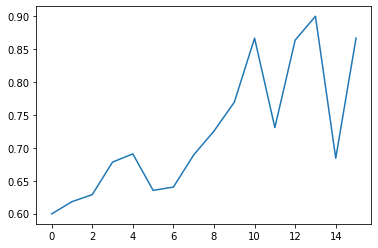

In [ ]:
plt.plot(acc_list)

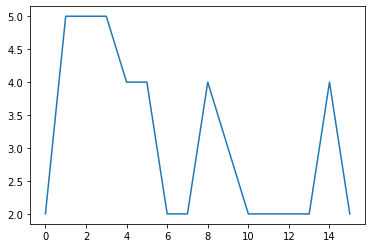

In [ ]:
plt.plot(max_depth_list)

In [ ]:
bac_list = []
auc_list = []

for i, depth in enumerate(max_depth_list):
  df_x_binary_train, df_y_binary_train, df_x_binary_val, df_y_binary_val, df_x_binary_test, df_y_binary_test = prepare_dataset(i + 1, extra_dim=False) 
  local_clf = build_decision_tree(df_x_binary_train, df_y_binary_train, max_depth = depth)
  prediction = local_clf.predict(df_x_binary_test)
  bac = balanced_accuracy_score(df_y_binary_test, prediction>0.5)
  auc = roc_auc_score(df_y_binary_test,prediction)
  bac_list.append(bac)
  auc_list.append(auc)


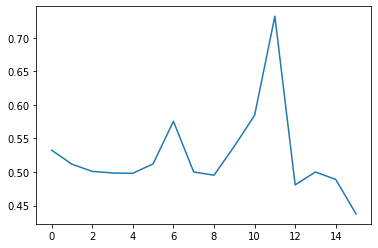

In [ ]:
plt.plot(bac_list)

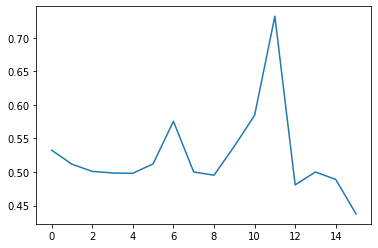

In [ ]:
plt.plot(auc_list)

# Deep Learning Model

In [ ]:
params = {}


params['batch_size'] = 32
#params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 16
params['epochs'] = 20
params['dropout_rate'] = 0.1

In [ ]:
def create_model_lstm_mooc_binary(nb_features, nb_skills, params):
    
    # Create an LSTM model architecture.
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    
    # We use a masking layer here to ignore our masked padding values
    #x = tf.keras.layers.Masking()(inputs)

    # This LSTM layer is the crux of the model; we use our parameters to specify
    # what this layer should look like (# of recurrent_units, fraction of dropout).
    # Note that return_sequences=False because we want a many-to-one architecture.
    x = tf.keras.layers.LSTM(params['recurrent_units'], 
                             return_sequences=False, 
                             dropout=params['dropout_rate'])(inputs)
    
        
    # We use a dense layer with the sigmoid function activation to map our predictions 
    # between 0 and 1.
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = dense(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='TimeSeries')

    # Compile the model with our loss functions, optimizer, and metrics.
    model.compile(loss=tf.keras.losses.binary_crossentropy, 
                  optimizer=params['optimizer'],
                  metrics=[tf.keras.metrics.AUC(), 'binary_accuracy'])    
    return model

num_features = 4
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)

In [ ]:
df_x_binary_train, df_y_binary_train, df_x_binary_val, df_y_binary_val, df_x_binary_test, df_y_binary_test = prepare_dataset(1) 
# We save only the best model during the training process.
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], 
                                                  save_best_only=True, save_weights_only=True)



# Fit the DKT LSTM on DSP1 data.
history = time_series_lstm.fit(df_x_binary_train, 
                               df_y_binary_train, 
                               epochs=params['epochs'],
                               validation_data=(df_x_binary_val, df_y_binary_val),
                               callbacks=[ckp_callback], 
                               verbose=params['verbose'])

Epoch 1/20
203/203 [==============================] - 4s 7ms/step - loss: 0.6828 - auc: 0.5063 - binary_accuracy: 0.5796 - val_loss: 0.6754 - val_auc: 0.5383 - val_binary_accuracy: 0.5939
Epoch 2/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6746 - auc: 0.5237 - binary_accuracy: 0.5938 - val_loss: 0.6733 - val_auc: 0.5426 - val_binary_accuracy: 0.5939
Epoch 3/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6739 - auc: 0.5232 - binary_accuracy: 0.5939 - val_loss: 0.6735 - val_auc: 0.5371 - val_binary_accuracy: 0.5939
Epoch 4/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6738 - auc: 0.5259 - binary_accuracy: 0.5941 - val_loss: 0.6732 - val_auc: 0.5392 - val_binary_accuracy: 0.5952
Epoch 5/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6730 - auc: 0.5355 - binary_accuracy: 0.5944 - val_loss: 0.6731 - val_auc: 0.5355 - val_binary_accuracy: 0.5958
Epoch 6/20
203/203 [==============================] - 1s 3ms

In [ ]:
# Load the best version of the the trained model and evaluate its performance on the test_set.
time_series_lstm.load_weights(params['best_model_weights'])
predictions = time_series_lstm.predict(df_x_binary_test)
bac = balanced_accuracy_score(df_y_binary_test, predictions>0.5)
auc = roc_auc_score(df_y_binary_test,predictions)
print("Balanced accuracy: ", bac)
print("AUC: ", auc)

Balanced accuracy:  0.5185647199920586
AUC:  0.550349870647129


In [ ]:
# Modify the dictionary of parameters so that each parameter maps to a list of possibilities.
# In this case, we're only searching over the recurrent_units and leaving the rest of the 
# parameters fixed to their default values.
params_space = {param: [value] for param, value in params.items()}
params_space['recurrent_units'] = [8, 16, 32, 64]
params_grid = ParameterGrid(params_space)

In [ ]:
# Conduct the gridsearch over hyperparameters.
# This cell should take ~3 minutes to run.
results = {}

# For each parameter setting in the grid search of parameters
for params_i in params_grid:

    # Create a LSTM model with the specific parameter setting params_i
    time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)

    save_model_name = params_i['best_model_weights'] + str(params_i['recurrent_units'])

    # Save the best version of the model through the training epochs
    ckp_callback = tf.keras.callbacks.ModelCheckpoint(save_model_name, 
                                                      save_best_only=True, save_weights_only=True)

    # Fit the model on the training data with the appropriate parameters  
    time_series_lstm.fit(df_x_binary_train, 
                         df_y_binary_train, 
                         epochs=params_i['epochs'],
                         validation_data=(df_x_binary_val, df_y_binary_val),
                         callbacks=[ckp_callback], 
                         verbose=params_i['verbose'])

    # Evaluate the model performance
    results[params_i['recurrent_units']] = time_series_lstm.evaluate(df_x_binary_val, 
                                                                     df_y_binary_val,
                                                                     verbose=params_i['verbose'], 
                                                                     return_dict=True)

Epoch 1/20
203/203 [==============================] - 3s 6ms/step - loss: 0.6841 - auc_1: 0.5042 - binary_accuracy: 0.5779 - val_loss: 0.6774 - val_auc_1: 0.5333 - val_binary_accuracy: 0.5946
Epoch 2/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6766 - auc_1: 0.5097 - binary_accuracy: 0.5938 - val_loss: 0.6743 - val_auc_1: 0.5387 - val_binary_accuracy: 0.5939
Epoch 3/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6747 - auc_1: 0.5214 - binary_accuracy: 0.5938 - val_loss: 0.6738 - val_auc_1: 0.5381 - val_binary_accuracy: 0.5939
Epoch 4/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6746 - auc_1: 0.5146 - binary_accuracy: 0.5938 - val_loss: 0.6736 - val_auc_1: 0.5395 - val_binary_accuracy: 0.5939
Epoch 5/20
203/203 [==============================] - 1s 3ms/step - loss: 0.6739 - auc_1: 0.5278 - binary_accuracy: 0.5938 - val_loss: 0.6733 - val_auc_1: 0.5418 - val_binary_accuracy: 0.5939
Epoch 6/20
203/203 [====================

In [ ]:
# Sort candidate parameters according to their accuracy
results = sorted(results.items(), key=lambda x: x[1]['binary_accuracy'], reverse=True)

# Obtain the best parameters
best_params = results[0][0]
best_params

8

In [ ]:
# Load the best model variant from the hyperparameter gridsearch
params['recurrent_units'] = best_params
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)
time_series_lstm.load_weights(params['best_model_weights'] + str(best_params))

predictions = time_series_lstm.predict(df_x_binary_test)
bac = balanced_accuracy_score(df_y_binary_test, predictions>0.5)
auc = roc_auc_score(df_y_binary_test,predictions)
print("Balanced accuracy: ", bac)
print("AUC: ", auc)

Balanced accuracy:  0.5134767053408453
AUC:  0.5466764314409525


Week 8

In [ ]:
n = 8
df_x_binary_train, df_y_binary_train, df_x_binary_val, df_y_binary_val, df_x_binary_test, df_y_binary_test = prepare_dataset(n) 

In [ ]:
params = {}

params['batch_size'] = 32
#params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 16
params['epochs'] = 2000
params['dropout_rate'] = 0.1

In [ ]:
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)

In [ ]:
# We save only the best model during the training process.
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], 
                                                  save_best_only=True, save_weights_only=True)

# Fit the DKT LSTM on DSP1 data.
history = time_series_lstm.fit(df_x_binary_train, 
                               df_y_binary_train, 
                               epochs=params['epochs'],
                               validation_data=(df_x_binary_val, df_y_binary_val),
                               callbacks=[ckp_callback], 
                               verbose=params['verbose'])

Epoch 1/2000
10/10 [==============================] - 3s 82ms/step - loss: 0.7126 - auc_6: 0.3944 - binary_accuracy: 0.4189 - val_loss: 0.6942 - val_auc_6: 0.5094 - val_binary_accuracy: 0.4730
Epoch 2/2000
10/10 [==============================] - 0s 8ms/step - loss: 0.6990 - auc_6: 0.3758 - binary_accuracy: 0.4797 - val_loss: 0.6808 - val_auc_6: 0.5072 - val_binary_accuracy: 0.5946
Epoch 3/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.6845 - auc_6: 0.3987 - binary_accuracy: 0.5777 - val_loss: 0.6687 - val_auc_6: 0.5341 - val_binary_accuracy: 0.7297
Epoch 4/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.6739 - auc_6: 0.4275 - binary_accuracy: 0.6453 - val_loss: 0.6569 - val_auc_6: 0.5750 - val_binary_accuracy: 0.6892
Epoch 5/2000
10/10 [==============================] - 0s 9ms/step - loss: 0.6607 - auc_6: 0.4591 - binary_accuracy: 0.6892 - val_loss: 0.6453 - val_auc_6: 0.6488 - val_binary_accuracy: 0.6892
Epoch 6/2000
10/10 [==================

In [ ]:
# Load the best version of the the trained model and evaluate its performance on the test_set.
time_series_lstm.load_weights(params['best_model_weights'])
predictions = time_series_lstm.predict(df_x_binary_test)
bac = balanced_accuracy_score(df_y_binary_test, predictions>0.5)
auc = roc_auc_score(df_y_binary_test,predictions)
print("Balanced accuracy: ", bac)
print("AUC: ", auc)

Balanced accuracy:  0.5630387931034483
AUC:  0.7155172413793103


In [ ]:
# Modify the dictionary of parameters so that each parameter maps to a list of possibilities.
# In this case, we're only searching over the recurrent_units and leaving the rest of the 
# parameters fixed to their default values.
params_space = {param: [value] for param, value in params.items()}
params_space['recurrent_units'] = [8, 16, 32, 64]
params_grid = ParameterGrid(params_space)

In [33]:
# Conduct the gridsearch over hyperparameters.
# This cell should take ~3 minutes to run.
results = {}

# For each parameter setting in the grid search of parameters
for params_i in params_grid:

    # Create a LSTM model with the specific parameter setting params_i
    time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)

    save_model_name = params_i['best_model_weights'] + str(params_i['recurrent_units'])

    # Save the best version of the model through the training epochs
    ckp_callback = tf.keras.callbacks.ModelCheckpoint(save_model_name, 
                                                      save_best_only=True, save_weights_only=True)

    # Fit the model on the training data with the appropriate parameters  
    time_series_lstm.fit(df_x_binary_train, 
                         df_y_binary_train, 
                         epochs=params_i['epochs'],
                         validation_data=(df_x_binary_val, df_y_binary_val),
                         callbacks=[ckp_callback], 
                         verbose=params_i['verbose'])

    # Evaluate the model performance
    results[params_i['recurrent_units']] = time_series_lstm.evaluate(df_x_binary_val, 
                                                                     df_y_binary_val,
                                                                     verbose=params_i['verbose'], 
                                                                     return_dict=True)

Выходные данные были обрезаны до нескольких последних строк (5000).
10/10 [==============================] - 0s 17ms/step - loss: 0.0417 - auc_9: 0.9991 - binary_accuracy: 0.9865 - val_loss: 1.1821 - val_auc_9: 0.7677 - val_binary_accuracy: 0.7838
Epoch 1503/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0384 - auc_9: 0.9993 - binary_accuracy: 0.9865 - val_loss: 1.1822 - val_auc_9: 0.7468 - val_binary_accuracy: 0.7432
Epoch 1504/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0530 - auc_9: 0.9984 - binary_accuracy: 0.9831 - val_loss: 1.1925 - val_auc_9: 0.7566 - val_binary_accuracy: 0.7297
Epoch 1505/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0394 - auc_9: 0.9995 - binary_accuracy: 0.9899 - val_loss: 1.2088 - val_auc_9: 0.7749 - val_binary_accuracy: 0.7703
Epoch 1506/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0338 - auc_9: 0.9997 - binary_accuracy: 0.9899 - val_loss: 1.1703 - val_auc_9: 0.780

In [34]:
# Sort candidate parameters according to their accuracy
results = sorted(results.items(), key=lambda x: x[1]['binary_accuracy'], reverse=True)

# Obtain the best parameters
best_params = results[0][0]
best_params

64

In [35]:
# Load the best model variant from the hyperparameter gridsearch
params['recurrent_units'] = best_params
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)
time_series_lstm.load_weights(params['best_model_weights'] + str(best_params))

predictions = time_series_lstm.predict(df_x_binary_test)
bac = balanced_accuracy_score(df_y_binary_test, predictions>0.5)
auc = roc_auc_score(df_y_binary_test,predictions)
print("Balanced accuracy: ", bac)
print("AUC: ", auc)

Balanced accuracy:  0.5662715517241379
AUC:  0.6697198275862069


In [36]:
# USE THIS PIPELINE TO APPLY TRANSFORMATIONS TO ONLY SOME COLUMNS

# preprocessor = ColumnTransformer(
#     transformers=[('scaler', StandardScaler(), columns_to_standarize)],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor)
# ]) # add your model in pipeline

# pipeline.fit(THE_DATA)


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

In [37]:
# Your code for training a model goes here

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [38]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*